# COGS 108 - Final Project 

# Overview

This project is aimed at determining whether or not there is a relationship between the reported number of violations by an inspector and the number of safety inspections they have completed that day. Two datasets were used and contained the data of thousands of food inspections conducted in Wake County. These were cleaned and processed so that the most relevant information could be merged and used to analyze any relationships between number of violations reported and the number of inspections conducted in a day and by one inspector. 

# Name & GitHub

- Name: Isabella Zendejas
- GitHub Username: izendeja
- PID: A15065059

# Research Question

Is there a relationship between the reported number of violations by an inspector and the number of safety inspections they have completed that day? 

## Background and Prior Work

An article from foodsafetynews.com explained the findings of Harvard researchers regarding the impact of safety inspectors' schedules on the number of violations reported. They concluded that there is a tendency for inspectors to become careless and fail to report violations if they are expected to review a lot of establishments in a day: "On average, inspectors cited fewer violations at each successive establishment inspected throughout the day, the researchers found." 
	
The issue of budget cuts was addressed in articles from foodsafetymagazine.com and dininggrades.com. They explained how nationwide budget cuts has a causal relationship with the impacted schedules of safety inspectors. When budget cuts are made, jobs are lost and fewer inspectors are available to manage the same workload within the same time frame. 
	
The Spokesman-Review wrote about the negative effects of budget cuts on public health and specifically for food-safety inspections. With the decrease in food-inspector jobs and the mass number of businesses that needed inspections, it was apparent that the process was highly susceptible to mistakes and overlooked violations: “On any given day, nine food safety inspectors fan out across Spokane County conducting surprise visits to about 2,300 businesses that serve food.”

References (include links):
- 1) https://www.foodsafetynews.com/2018/05/harvard-researchers-say-fixing-food-safety-inspectors-schedules-could-end-many-violations/  

- 2) https://www.foodsafetymagazine.com/enewsletter/challenges-of-health-department-food-safety-inspections/

- 3) https://www.dininggrades.com/blog/problems-with-restaurant-food-safety-grading/
    
- 4)  https://www.spokesman.com/stories/2011/nov/13/critical-condition/![image.png](attachment:image.png)


# Hypothesis


My background research suggests that the schedule of a food-inspector should have a high correlation with the number of violations they report because an increased number of bookings requires that less time be spent at each business. For this reason, I expect that the average number of violations that an inspector reports has a negative correlation with the number of inspections they completed within that same day. 


# Dataset(s)


- Dataset Name: Inspections
- Link to the dataset: (provided)
- Number of observations: 18466 
- Description: Table including a random sample of data collected from all Wake County sanitation inspections from September 20, 2012 to November of 2016. Relevant information to the research question include the identification for each restaurant, date and type of inspection, and the identification of the inspector.


- Dataset Name: Violations
- Link to the dataset: (provided)
- Number of observations: 189803
- Description: Table including a random sample of data collected from all violations identified during Wake County sanitations inspections since September 20, 2012. Provides further description of the identified violations from the inspections.


- Combining datasets: I will use the hsisd, inspection date, and inspector id/name to match the data from the Inspections and Violations tables so that I have a combined table with all information for each recorded inspection. Any inspections that are not recorded in both tables will be excluded from the final dataset. 


# Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest


# Data Cleaning

###  Load the data
Import csv files into dataframes.

In [2]:
insp_df = pd.read_csv("inspections.csv")
viol_df = pd.read_csv("violations.csv")

insp_df.insert(0, "inspectionid", insp_df.index)

insp_df.head(2)


,inspectionid,hsisid,date,name,address1,address2,city,state,postalcode,phonenumber,...,num_non_critical,num_critical_previous,num_non_critical_previous,num_critical_mean_previous,num_non_critical_mean_previous,avg_neighbor_num_critical,avg_neighbor_num_non_critical,top_match,second_match,critical
0,0,4092013748,2012-09-21T00:00:00Z,Cafe 3000 At Wake Med,3000 New Bern Ave,NaN,raleigh,NC,27610,(919) 350-8047,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,4092014046,2012-09-21T00:00:00Z,Overtime Sports Pub,1030-149 N Rogers Ln,NaN,raleigh,NC,27610,(919) 255-9556,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Drop columns that are not relevant to research question

We only need columns that provide data that can be used to match corresponding inspections across both tables and that are directly related to research question. 

In [3]:
insp1 = insp_df.loc[:, 'inspectionid':'date']
insp2 = insp_df.loc[:, 'description':'inspector_id']
insp_df = insp1.merge(insp2, left_index=True, right_index=True)

insp_df.head(2)


,inspectionid,hsisid,date,description,inspectedby,inspection_num,inspector_id
0,0,4092013748,2012-09-21T00:00:00Z,This facility cooks eggs to order in Grill sta...,Melissa Harrison,1,27.0
1,1,4092014046,2012-09-21T00:00:00Z,NaN,Christopher Walker,1,7.0


In [4]:
viol1 = viol_df.loc[:, 'hsisid':'inspectdate']
viol2 = viol_df.loc[:, 'inspectedby']
viol_df = viol1.merge(viol2, left_index=True, right_index=True)
viol_copy_df = viol_df

viol_copy_df.head(2)

,hsisid,inspectdate,inspectedby
0,4092015279,2014-09-22T00:00:00.000Z,Lucy Schrum
1,4092014572,2014-09-29T00:00:00.000Z,Daryl Beasley


###  Combine datasets

Match the inspection id with hsisid, date, and inspector name from Inspections table to find corresponding Violations data for the given inspection. Return total number of violations reported.


In [5]:
def inspectionid_matcher(hsisid, inspectdate, inspectedby): 
    temp = viol_df.loc[viol_df['hsisid'] == hsisid]
    temp = temp.loc[temp['inspectdate'] == inspectdate]
    temp = temp.loc[temp['inspectedby'] == inspectedby] 

    return len(temp)
    

In [6]:
#ASSERT FUNCTION CORRECTNESS

assert inspectionid_matcher(4092015279, "2014-09-22T00:00:00.000Z", "Lucy Schrum") != 0
assert inspectionid_matcher(4092014046, "2012-09-21T00:00:00Z", "Christopher Walker") == 0

Iterate through Violations data using inspectionid_matcher function to match each inspection with corresponding number of violations

In [7]:
viol_list = []

for i in range(0, len(insp_df)):
    hsisid = insp_df.loc[i, 'hsisid']
    inspectdate = insp_df.loc[i, 'date']
    inspectedby = insp_df.loc[i, 'inspectedby']
    total = inspectionid_matcher(hsisid, inspectdate, inspectedby)
    viol_list.append(total)


Add new column to insp_df titled "total_violations" and insert values from this list

In [8]:
temp_df = pd.DataFrame({'total_violations':viol_list})
temp_df

insp_df = insp_df.merge(temp_df, left_index=True, right_index=True)
insp_df = insp_df.drop(columns=['description', 'inspectedby', 'inspection_num'])

insp_df.head(5)

,inspectionid,hsisid,date,inspector_id,total_violations
0,0,4092013748,2012-09-21T00:00:00Z,27.0,0
1,1,4092014046,2012-09-21T00:00:00Z,7.0,0
2,2,4092015191,2012-09-21T00:00:00Z,3.0,0
3,3,4092016122,2012-09-21T00:00:00Z,24.0,0
4,4,4092021513,2012-09-21T00:00:00Z,7.0,0


### Summary of data cleaning process: 

All of the above steps ensured that the final dataframe did not include any privacy-breaching information and excluded the clutter of irrelevant variables. The data is now formatted as a single dataframe that includes rows of every food-inspection that is split into column categories which include the restaurant id, date of inspection, inspector id, and number of violations reported. These are the most relevant data variables we need to conduct the analysis for our research question. 


# Data Analysis & Results

### Approach: 

Use inspection dates and inspector id to determine how many inspections each person conducted within one day. Use this to create table of dates...

In [9]:
#Total number of inspectors
total = insp_df['inspector_id'].max()


Function find_schedule() takes as parameters an inspector_id and date of inspection to create table of all inspections conducted by that inspector on that day. Returns the total number of inspections, total number of violations reported, and average number of violations reported per inspection in the format of a list.

In [10]:
def find_schedule(inspector_id, date):
    
    #Table of inspections from inputted inspector id
    df = insp_df.loc[insp_df['inspector_id'] == inspector_id]

    #Table of all inspections by inputted inspector during the inputted date 
    df = df.loc[insp_df['date'] == date]

    #Total number of inspections that day
    num_appts = len(df)

    #Total number of violations reported that day
    num_viol = df.loc[:, 'total_violations'].sum()

    #Averge number of violations reported per inspection on that day
    avg_viol = df.loc[:, 'total_violations'].mean()
    
    list = [num_appts, num_viol, avg_viol]
    
   # pin = pd.Series(df['inspectionid'].values)


    return list


In [12]:
unique_list = []

for i in range(0, len(insp_df)):
    inspector_id = insp_df.loc[i, 'inspector_id']
    date = insp_df.loc[i, 'date']
    list1 = find_schedule(inspector_id, date)
    unique_list.append(list1)
  

In [14]:
#find_schedule(24, "2012-09-21T00:00:00Z")
#insp_df
unique_list
len(unique_list)

18466

### Visualizations

Scatter matrix plotting the Inspections dataframe

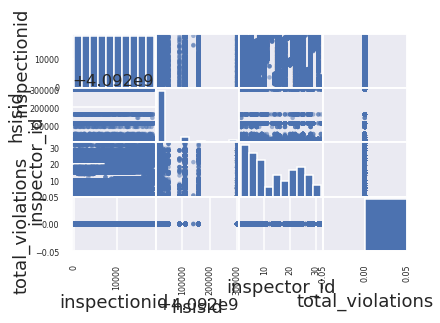

In [15]:
fig = pd.plotting.scatter_matrix(insp_df)

# Ethics & Privacy

The two datasets used in this analysis were provided by the professor for the purpose of this assignment.

Any privacy concerns were addressed through the data cleaning process. After considerable processing and merging, any identifiable data that remained was dropped from the final dataset. 

The datasets that were used appear to have been formatted in a reasonable and unbiased manner. However, the data only reflects the food inspections of a single county. Therefore, it is a very concentrated sample of data that should not be used to make generalizations about the food inspection process throughout the country or for any other large population. 


# Conclusion & Discussion


The primary research question focused on  determining the existence of a relationship between the reported number of violations by an inspector and the number of safety inspections they have completed that day. Based off of background research regarding the impact of budget cuts on the accuracy of food inspections, I hypothesized that there would be a negative correlation between the number of inspections an inspector is required to complete in a day and the average number of violations they actually report. 

The two datasets used were highly correlated with each other and expressed different data for the large set of recorded inspections in Wake County throughout the past few years. I used the hsisd, inspection date, and inspector id/name to match the data from the Inspections and Violations tables. 

A limitation to the generalizability of this analysis is due to the fact that the data only reflects the food inspections of a single county. Therefore, it is a very concentrated sample of data that should not be used to make generalizations about the food inspection process throughout the country or for any other large population. 

